In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


corrientes = pd.read_csv('corrientes.csv')
potencias = pd.read_csv('potencias.csv')

corrientes['timestamp'] = pd.to_datetime(corrientes['timestamp'])
potencias['timestamp'] = pd.to_datetime(potencias['timestamp'])

# Unir los dataframes en base al ID y timestamp
merged_df = pd.merge(corrientes, potencias, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
merged_df['año'] = merged_df['timestamp'].dt.year
merged_df['mes'] = merged_df['timestamp'].dt.month
merged_df['dia'] = merged_df['timestamp'].dt.day
merged_df['hora'] = merged_df['timestamp'].dt.hour
merged_df['minuto'] = merged_df['timestamp'].dt.minute

# Seleccionar y reorganizar las columnas en el formato deseado
final_df = merged_df[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3']]

# Mostrar el dataframe resultante
print(final_df)

         año  mes  dia  hora  minuto  activa  reactiva  aparente     l1  \
0       2021    1    1     0       0  13.584     9.264    16.444  29.16   
1       2021    1    1     0      15  12.492     9.840    15.904  27.30   
2       2021    1    1     0      30  12.468    10.056    16.016  27.12   
3       2021    1    1     0      45  13.032     9.060    15.872  27.18   
4       2021    1    1     1       0  12.540     9.720    15.868  27.12   
...      ...  ...  ...   ...     ...     ...       ...       ...    ...   
117200  2024    5    6     8      45  45.840     3.564    45.980  74.16   
117201  2024    5    6     9       0  52.092     3.084    52.184  77.97   
117202  2024    5    6     9      15  51.996     2.448    52.052  74.55   
117203  2024    5    6     9      30  53.472     2.316    53.524  77.43   
117204  2024    5    6     9      45  59.472     2.280    59.516  82.71   

            l2     l3  
0        25.62  20.85  
1        24.81  20.34  
2        25.56  20.64  
3  

#
aa
#Ver
#
ss

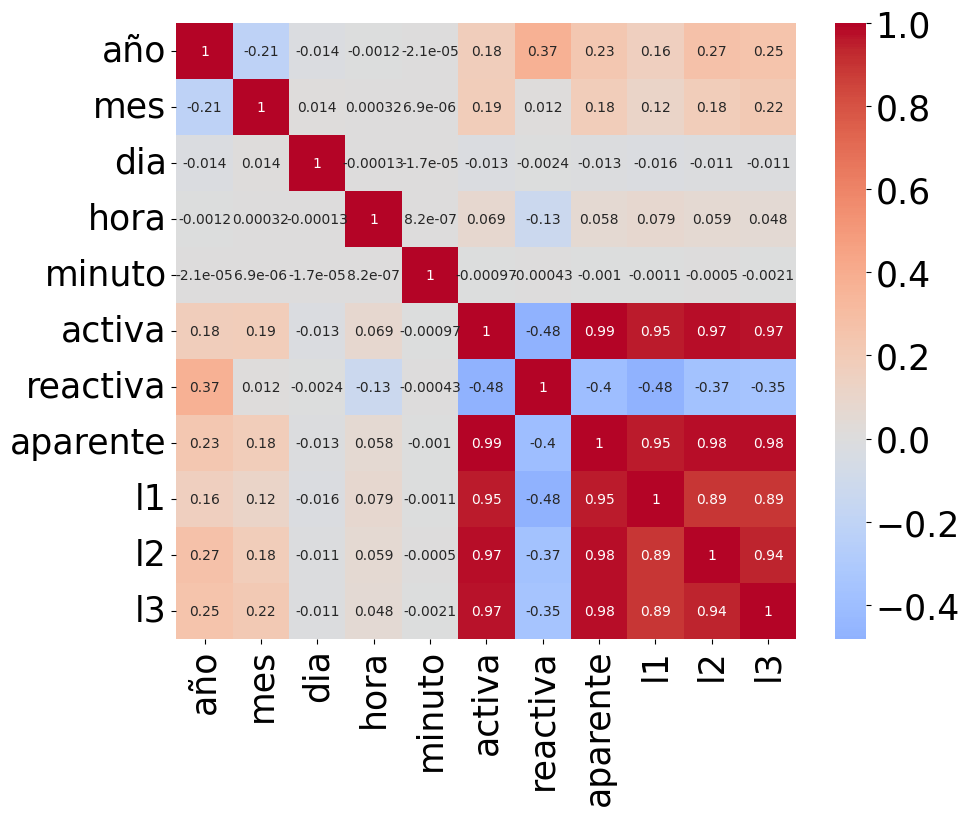

año         0.175960
mes         0.187779
dia        -0.012915
hora        0.068827
minuto     -0.000972
activa      1.000000
reactiva   -0.481186
aparente    0.994164
l1          0.950231
l2          0.972447
l3          0.968129
Name: activa, dtype: float64


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = final_df.corr()

# Generar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

# Mostrar el mapa de calor
plt.show()

# Mostrar las correlaciones con la potencia activa
print(corr_matrix['activa'])

<function matplotlib.pyplot.show(close=None, block=None)>

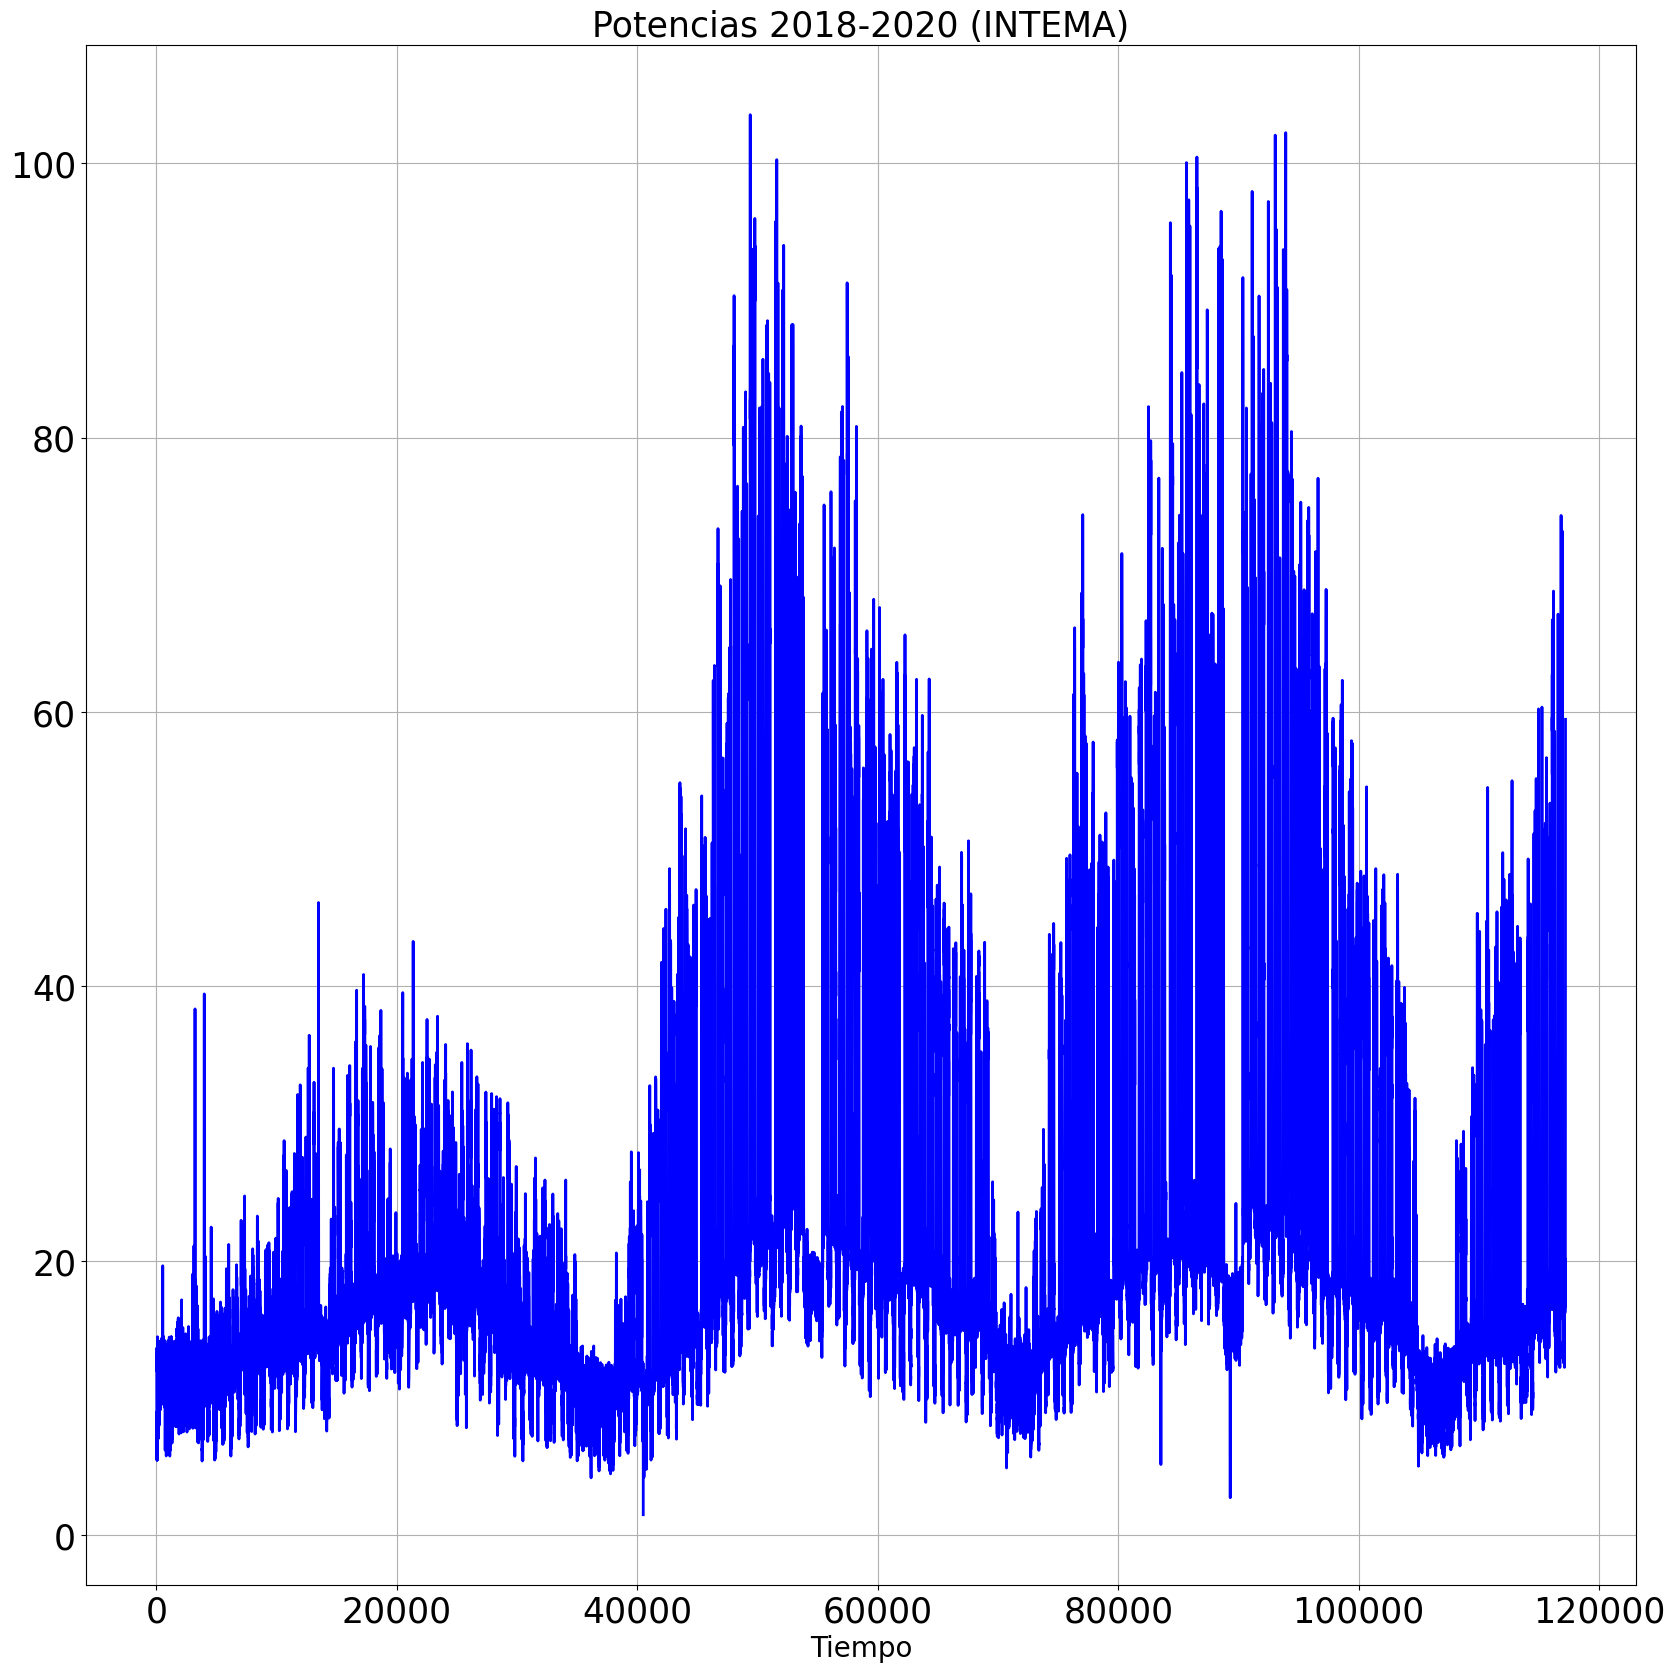

In [28]:

plt.plot(final_df["activa"],'b', linewidth = 2)
plt.rcParams['figure.figsize'] = [20, 20]

plt.grid(True)
plt.title("Potencias 2018-2020 (INTEMA)", fontsize = 25)
plt.xlabel("Tiempo", fontsize = 20)
#plt.ylabel("P [kW]", fontsize = 20)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.show


In [29]:
final_df_copy = final_df.copy()

In [30]:

# Función para crear ventanas deslizantes
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])  # Indexar correctamente para un array unidimensional
    return np.array(X), np.array(y)

# Crear las ventanas deslizantes
mediciones_ventana = 4


activapre, activapost = create_windows(final_df_copy['activa'], mediciones_ventana)
aparentepre, aparentepost = create_windows(final_df_copy['aparente'], mediciones_ventana)
reactivapre, reactivapost = create_windows(final_df_copy['reactiva'], mediciones_ventana)
mespre, mespost = create_windows(final_df_copy['mes'], mediciones_ventana)
diapre, diapost = create_windows(final_df_copy['dia'], mediciones_ventana)
minutopre, minutopost = create_windows(final_df_copy['minuto'], mediciones_ventana)
i1pre, i1post = create_windows(final_df_copy['l1'], mediciones_ventana)
i2pre, i2post = create_windows(final_df_copy['l2'], mediciones_ventana)
i3pre, i3post = create_windows(final_df_copy['l3'], mediciones_ventana)

#print(activapre)
#print(activapost)

In [31]:
#Armamos los datos con el formato que queremos
X = np.concatenate([activapre, aparentepre, reactivapre, mespre, diapre, minutopre, i1pre, i2pre, i3pre], axis=1)
y = activapost  # Supongamos que queremos predecir la 'activa' post ventana

archivo_salida = 'datos.txt'

nombre_columna = 'X'

# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre las filas del array X
    for fila in X:
        # Convierte cada fila a una cadena de texto con valores separados por comas
        fila_str = ','.join(map(str, fila))
        # Escribe la fila en el archivo y añade una nueva línea
        f.write(f"{fila_str}\n")


In [32]:
# Proporciones para cada conjunto
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Divide los datos en entrenamiento y temporal (validación + prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=42)

# Calcula la proporción de validación y prueba en el conjunto temporal
val_size_temp = val_size / (val_size + test_size)

# Divide el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_size_temp), random_state=42)

# Verifica las formas de los conjuntos
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (82040, 36)
Forma de X_val: (17580, 36)
Forma de X_test: (17581, 36)
Forma de y_train: (82040,)
Forma de y_val: (17580,)
Forma de y_test: (17581,)


In [33]:

scalerX = StandardScaler()
scalery = StandardScaler()

# Assuming y is a 1D array, reshape it to 2D
y_reshaped = y.reshape(-1, 1)

# Fit and transform X and y_scaled
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.fit_transform(X_test)


y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = scalery.fit_transform(y_train)
y_val = scalery.fit_transform(y_val)
y_test = scalery.fit_transform(y_test)


In [34]:
promedio = np.nanmean(y_train)
# Reemplazar NaN por el promedio calculado
y_train[np.isnan(y_train)] = promedio

promedio = np.nanmean(X_train)
# Reemplazar NaN por el promedio calculado
X_train[np.isnan(X_train)] = promedio

promedio = np.nanmean(X_val)
# Reemplazar NaN por el promedio calculado
X_val[np.isnan(X_val)] = promedio

promedio = np.nanmean(y_val)
# Reemplazar NaN por el promedio calculado
y_val[np.isnan(y_val)] = promedio

promedio = np.nanmean(X_test)
# Reemplazar NaN por el promedio calculado
X_test[np.isnan(X_test)] = promedio

promedio = np.nanmean(y_test)
# Reemplazar NaN por el promedio calculado
y_test[np.isnan(y_test)] = promedio


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 60)                2220      
                                                                 
 dense_21 (Dense)            (None, 42)                2562      
                                                                 
 dense_22 (Dense)            (None, 22)                946       
                                                                 
 dense_23 (Dense)            (None, 1)                 23        
                                                                 
Total params: 5751 (22.46 KB)
Trainable params: 5751 (22.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2564/2564 [==============================] - 9s 3ms/step - loss: 0.0220 - mae: 0.0854 - val_loss: 0.0123 - val_mae: 0.0739
Epoch 2/20
2564/25

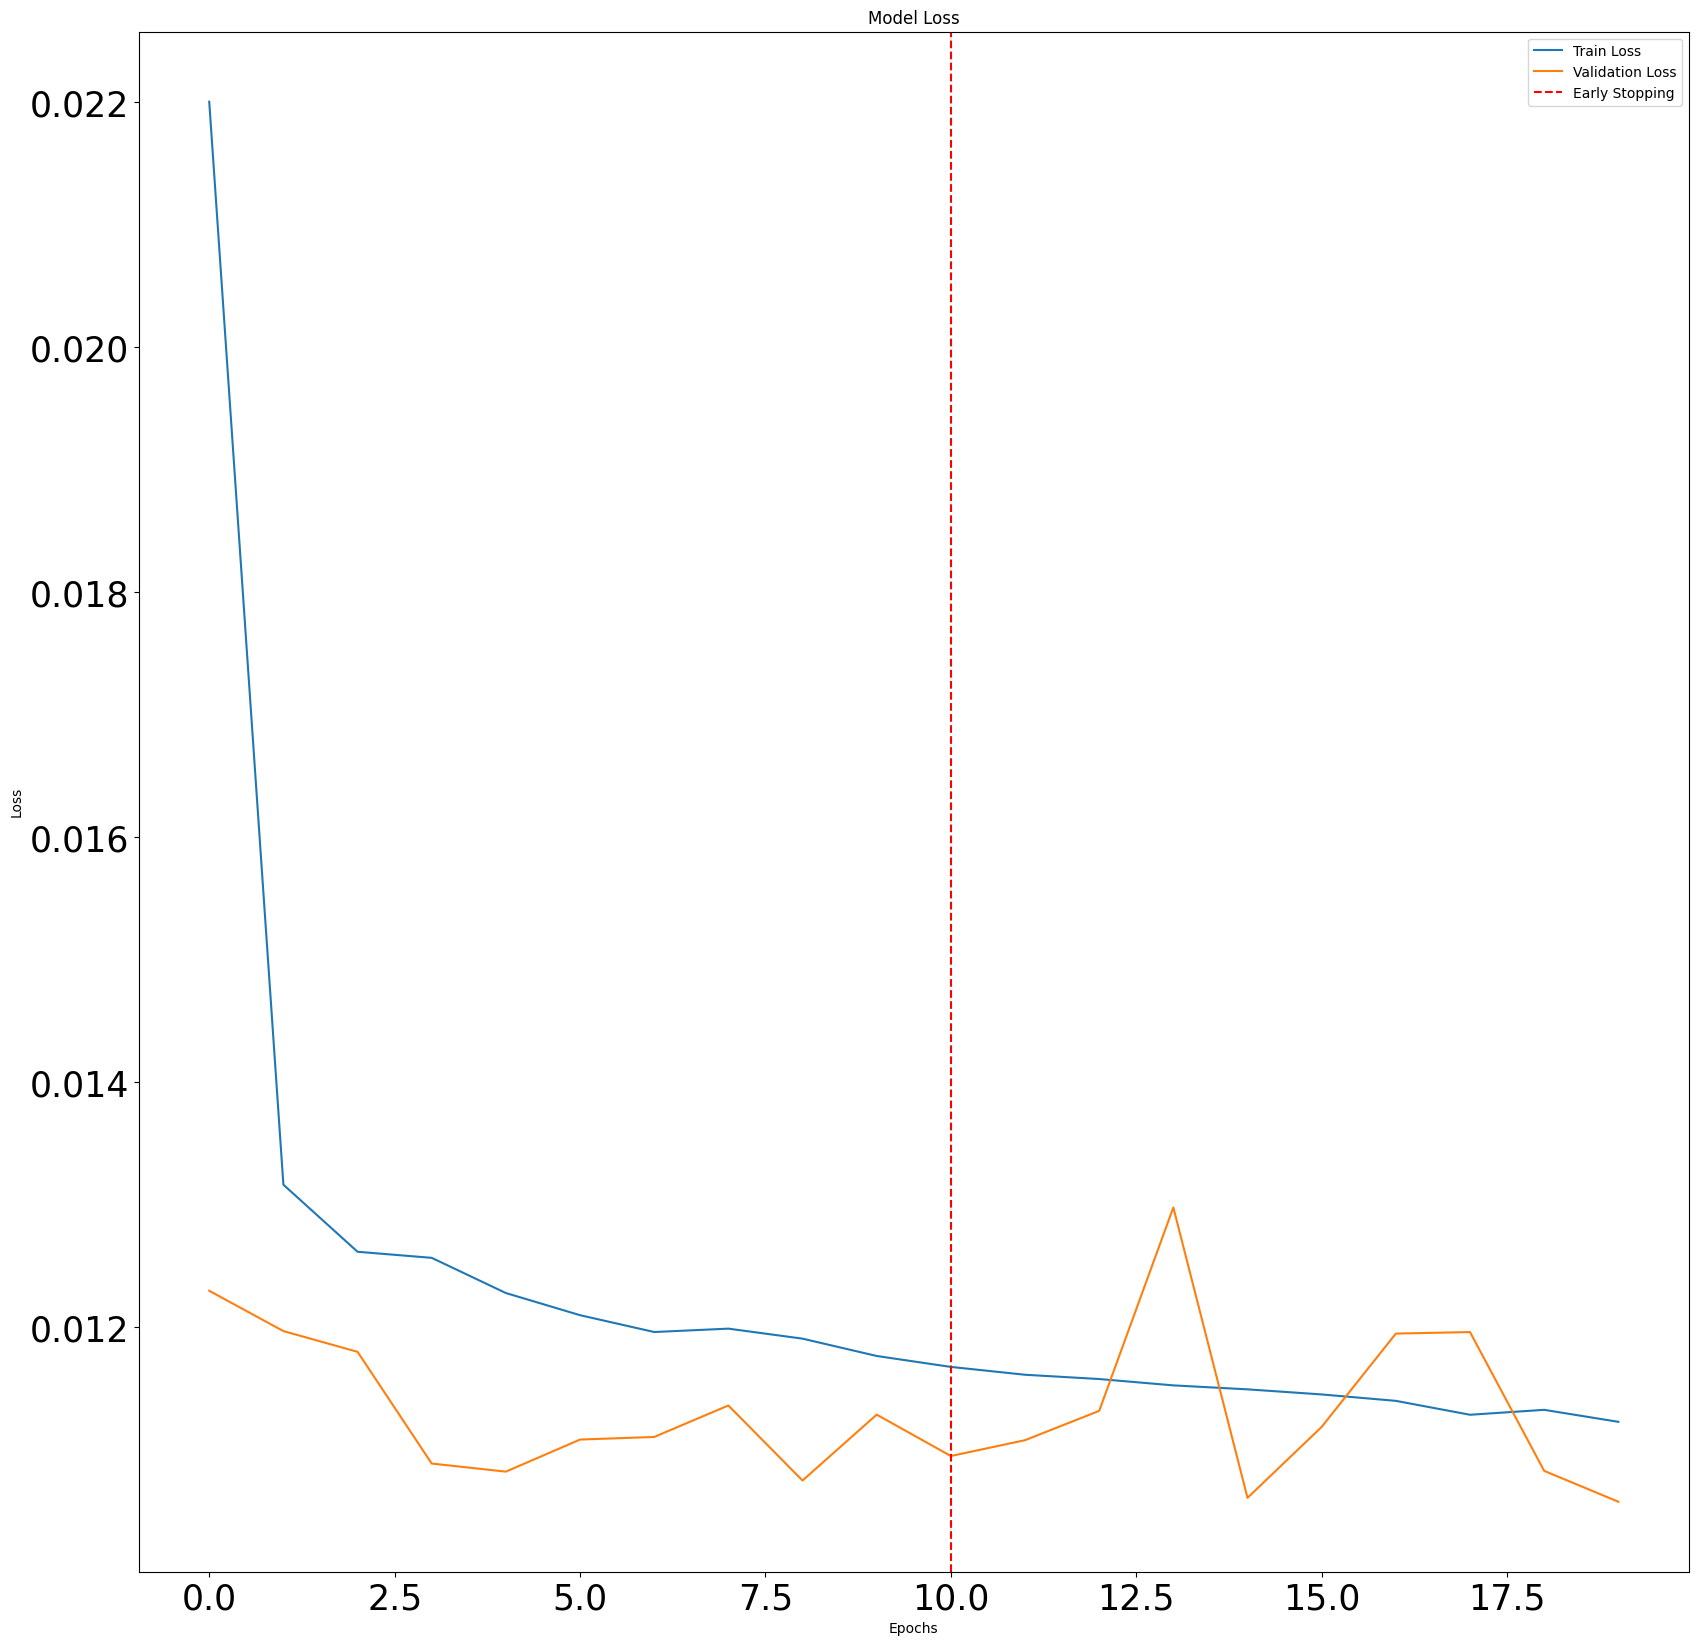

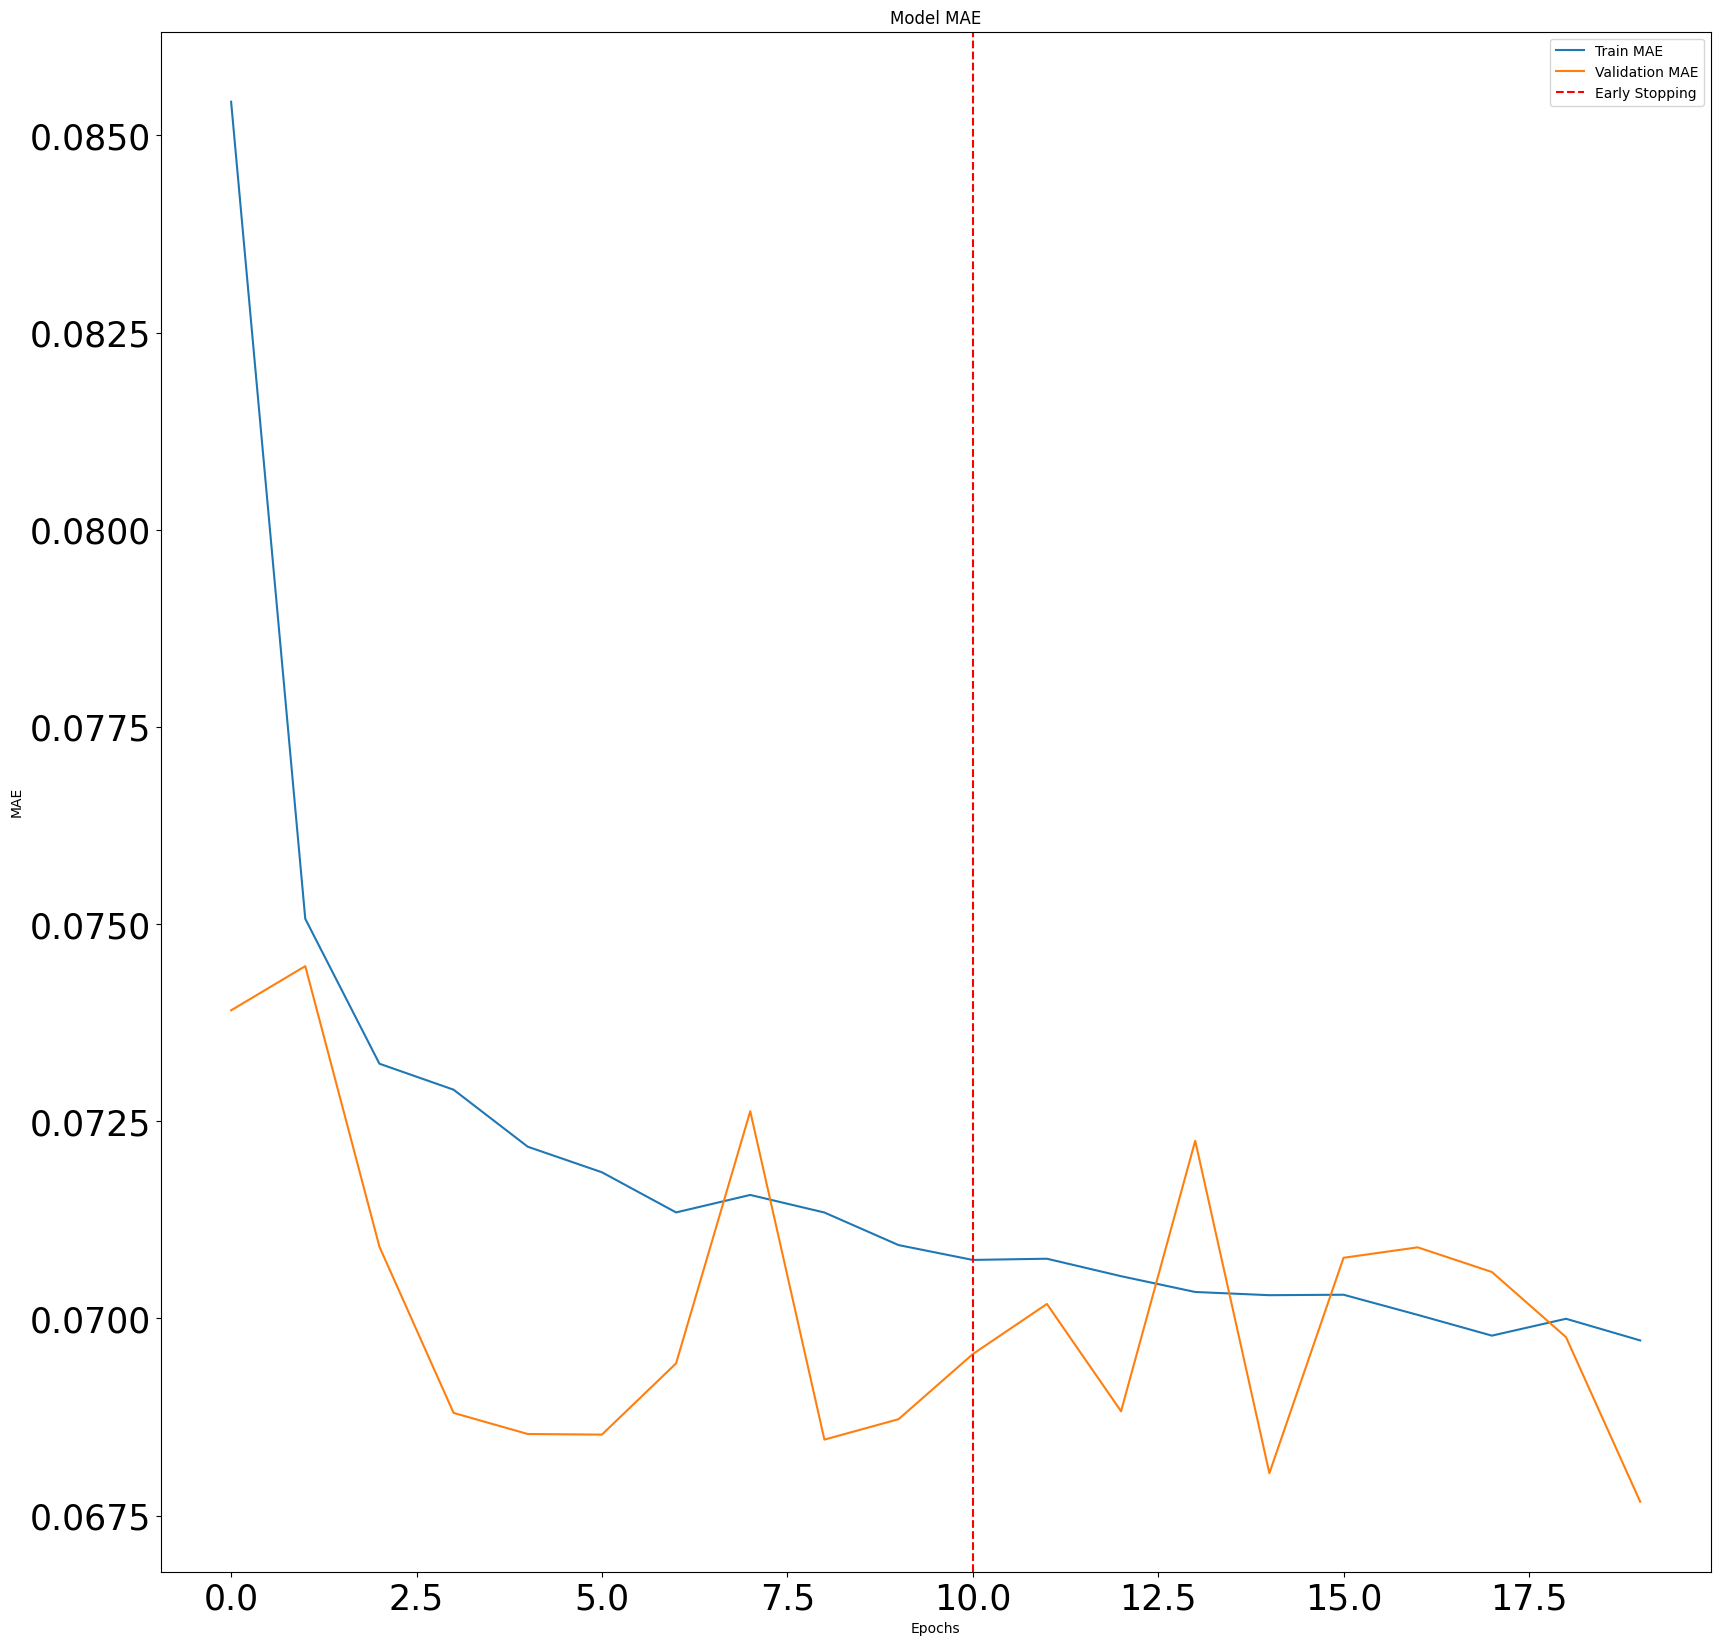

In [42]:

model = Sequential()
model.add(Dense(60, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(42, activation='relu'))
model.add(Dense(22, activation='relu'))
model.add(Dense(1, activation='linear')) # Suponiendo que estás prediciendo un valor continuo

# Definir el optimizador con el learning rate deseado
optimizer = Adam(learning_rate=0.001)

# Compilar el modelo especificando el optimizador y otras configuraciones
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping],  verbose=1)
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)


# Gráfica de la pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=len(history.history['loss']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfica del MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.axvline(x=len(history.history['mae']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
copia_datos = X
copia_datos
copia_datos2 = copia_datos
print(copia_datos)

In [ ]:
datos_escalados = scalerX.fit_transform(copia_datos2)
print(datos_escalados)

In [ ]:
datos_desescalados = scalerX.inverse_transform(datos_escalados)
print(datos_desescalados)

In [ ]:
X_test[:,4]

archivo_salida = "datos_en_test.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for valor_y in X_test:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{valor_y}\n")


X_test_desestandarizado = scalerX.inverse_transform(X_test)
archivo_salida = "datos_en_test_desestandarizado.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in X_test_desestandarizado:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")


archivo_salida = "datos_en_x.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in X:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")

In [ ]:
# Hacer predicciones con los datos de prueba
y_test_pred = model.predict(X_test[25,:].reshape(1, -1))
y_test[25]
print(y_test_pred)
# X ENTRA año  mes  dia  hora  minuto  activa  reactiva  aparente l1 L2 L2
input_data = np.array([0.11835867,  0.09746048,  0.02965695,  0.10309789,  0.18152911 , 0.16393361,
                       0.11301236,  0.1646457,   1.12972061,  1.14726251 , 1.23655089,  1.11053278,
                       0.53465572,  0.53495438 , 0.53488847 , 0.53481257 ,-1.10291196 ,-1.10285512,
                      -1.10314401 ,-1.10344726,  0.44668967 , 1.33936005 ,-1.34082598 ,-0.44214717,
                      -0.42645304 ,-0.43415975, -0.51742309 ,-0.44604964 , 0.78809792, 0.76781543,
                       0.72352641 , 0.78930282, -0.00159766, -0.04054386, -0.06245636 ,-0.02779989])

# Ajusta la forma para que coincida con las características utilizadas durante el entrenamiento
input_data = input_data.reshape(1, -1) #si se ocmenta no anda

# Realiza la predicción
y_test_pred = model.predict(input_data)

print(y_test_pred)
y_test_pred = scalery.inverse_transform(y_test_pred)
print(y_test_pred)

#a = scalery.inverse_transform([-0.07620964])
#print(a)


plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_test_pred, label='Predicción')
plt.xlabel('Índice de muestra')
plt.ylabel('Potencia Activa')
plt.title('Predicción vs Actual (Datos de Entrenamiento)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_test = scalery.inverse_transform(y_test)


In [ ]:
y_test_pred = model.predict(X_test[156,:].reshape(1, -1))
print(y_test_pred)

y_test_pred = scalery.inverse_transform(y_test_pred)
print(y_test_pred)

#a = scalery.inverse_transform([-0.07620964])
print("en test esa pos tenia")
print(y_test[156])


plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_test_pred, label='Predicción')
plt.xlabel('Índice de muestra')
plt.ylabel('Potencia Activa')
plt.title('Predicción vs Actual (Datos de Entrenamiento)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que model es tu modelo ya entrenado y X_test, y_test son tus datos de prueba
# Hacemos predicciones
y_test_pred = model.predict(X_test)

has_nan = np.isnan(y_test_pred).any()
print("¿Hay NaN en los datos y_test_pred?", has_nan)
nan_positions = np.argwhere(np.isnan(y_test_pred))
print("Posiciones de NaN en los datos X:")
print(nan_positions)

y_test_pred[np.isnan(y_test_pred)] = promedio

y_test_pred = scalery.inverse_transform(y_test_pred)



has_nan = np.isnan(y_test).any()
print("¿Hay NaN en los datos y_Test?", has_nan)
nan_positions = np.argwhere(np.isnan(y_test))
print("Posiciones de NaN en los datos X:")
print(nan_positions)

y_test[np.isnan(y_test)] = promedio


# Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_test_pred)



# Calculamos otras métricas de error
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

# Imprimimos las métricas de error
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Definimos un margen de error aceptable (por ejemplo, 10 unidades) 12.45
margin_of_error = 10

# Calculamos cuántas predicciones están dentro del margen de error
within_margin = np.sum(np.abs(y_test - y_test_pred) <= margin_of_error)
total_predictions = len(y_test)
accuracy_within_margin = within_margin / total_predictions

# Imprimimos la precisión dentro del margen de error
print(f'Número de predicciones dentro del margen de error: {within_margin}')
print(f'Precisión dentro del margen de error: {accuracy_within_margin:.2%}')

# Guardamos los resultados en un DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Error': y_test - y_test_pred
})

# Guardamos los resultados en un archivo CSV
results_df.to_csv('predictions_and_errors.csv', index=False)

# Guardamos las métricas de error en un archivo JSON
import json

metrics = {
    'MSE': mse,
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2,
    'Precision within margin': accuracy_within_margin
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f)

In [ ]:
archivo_salida = "datos_estimados.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in y_test_pred:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")

In [ ]:
archivo_salida = "datos_en_y_test.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in y_test:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")

In [ ]:

# Plot de datos de entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual (Train)', marker='o')
plt.plot(y_test_pred, label='Predicted (Train)', marker='x')
plt.title('Comparación de Predicciones y Valores Reales (Datos de Entrenamiento)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')
plt.legend()
plt.grid(True)
plt.show()

# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los datos reales y predichos como líneas
plt.plot(y_test, label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred, label='Predichas (Test)', linestyle='-', color='red')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()



# Calculamos el error (diferencia entre los valores reales y predichos)
error = y_test[:50] - y_test_pred[:50]

# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los primeros 50 datos reales y predichos como líneas
plt.plot(y_test[:50], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[:50], label='Predichas (Test)', linestyle='-', color='red')

# Ploteamos el error como línea
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()






# Plot de datos de prueba
plt.figure(figsize=(12, 6))

error = y_test[50:100] - y_test_pred[50:100]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[50:100], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[50:100], label='Predichas (Test)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


# Plot de datos de prueba
plt.figure(figsize=(12, 6))
error = y_test[300:400] - y_test_pred[300:400]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[300:400], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[300:400], label='Predichas (Test)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()





# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[850:1000], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[850:1000], label='Predichas (Test)', linestyle='-', color='red')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


error = y_test - y_test_pred
print((error))


# Creamos un histograma del error
plt.figure(figsize=(12, 6))
plt.xlim(-15, 15)

plt.hist(error, bins=500, edgecolor='black', color='blue')

# Añadimos título y etiquetas
plt.title('Histograma del Error (Reales - Predichas)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

# Mostramos el gráfico
plt.grid(True)
plt.show()

In [ ]:
std_deviation = np.std(error)

print(f"Desviación estándar del error: {std_deviation:.2f}")